# AI Sampleset : Frequeny Response Flatness

In [1]:
import torch as tch
import tikzplotlib
import matplotlib.pyplot as plt
import torchaudio
import IPython
import soundfile
import numpy as np
import scipy

#good sample
path1 = "../sampleset/full/WDH_KICK_D#02.wav"
#terrible sample
path2 = "../sampleset/bad/THT_Kicks_21.wav"
#decent, but bad envelope
path3 = "../sampleset/bad/bad_envelope.wav"
#clicky transient
path4 = "../sampleset/full/A_Kick_09.wav"
#above sample, but transient reverbed
path5 = "../sampleset/full/simplosive-deepkicks-013a.wav"

sample1 = torchaudio.load(path1)[0][0]
sample2 = torchaudio.load(path2)[0][0]
sample3 = torchaudio.load(path3)[0][0]
sample4 = torchaudio.load(path4)[0][0]
sample5 = torchaudio.load(path5)[0][0]

Fs = 44100

C:\Users\damen\anaconda3\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\damen\anaconda3\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
from scipy.signal import welch, find_peaks
from scipy.stats import gmean

def rms(x):
    return np.sqrt(np.mean(x**2))

def last_peak(sample):
    pks, _ = find_peaks(sample, width=64, height=5e-2)
    return pks[len(pks)-1]

def spectrum(sample):
    return welch(sample, nfft = 1024, fs = Fs, detrend='linear', nperseg=1024)

def logstd(arr):
    m = 20*np.log10(np.mean(arr))
    a = 20*np.log10(arr)
    return np.sqrt(np.mean((a - m)**2))
    
def flatness(arr):
    gm = gmean(arr)
    if gm == 0.0:
        return 0.0
    else:
        return gm / np.mean(arr)

def deviation(arr):
    return np.std(arr)

In [3]:
from numpy import pi, polymul
from scipy.signal import bilinear, lfilter

#code from https://gist.github.com/endolith/148112
def A_weighting(fs):
    """Design of an A-weighting filter.
    b, a = A_weighting(fs) designs a digital A-weighting filter for
    sampling frequency `fs`. Usage: y = scipy.signal.lfilter(b, a, x).
    Warning: `fs` should normally be higher than 20 kHz. For example,
    fs = 48000 yields a class 1-compliant filter.
    References:
       [1] IEC/CD 1672: Electroacoustics-Sound Level Meters, Nov. 1996.
    """
    # Definition of analog A-weighting filter according to IEC/CD 1672.
    f1 = 20.598997
    f2 = 107.65265
    f3 = 737.86223
    #f4 = 12194.217
    f4 = 30000
    A1000 = 1.9997

    NUMs = [(2*pi * f4)**2 * (10**(A1000/20)), 0, 0, 0, 0]
    DENs = polymul([1, 4*pi * f4, (2*pi * f4)**2],
                   [1, 4*pi * f1, (2*pi * f1)**2])
    DENs = polymul(polymul(DENs, [1, 2*pi * f3]),
                                 [1, 2*pi * f2])

    # Use the bilinear transformation to get the digital filter.
    # (Octave, MATLAB, and PyLab disagree about Fs vs 1/Fs)
    return bilinear(NUMs, DENs, fs)

filt_b, filt_a = A_weighting(Fs)

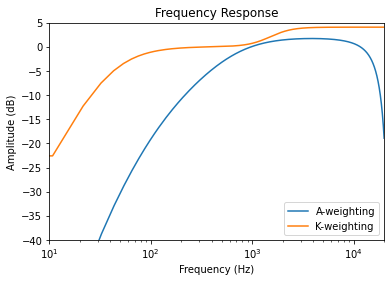

In [8]:
from math import tan,pi

# Adapted from the C++ code in https://github.com/jiixyj/libebur128/blob/v1.0.2/ebur128/ebur128.c#L82
def K_weighting(sampleRate):
    f0 = 1681.974450955533
    G  = 3.999843853973347
    Q  = 0.7071752369554196

    K  = tan(pi * f0 / sampleRate)
    Vh = pow(10.0, G / 20.0)
    Vb = pow(Vh, 0.4996667741545416)
    a0 = 1.0 + K / Q + K * K

    filterB1 = np.empty(3)
    filterA1 = np.empty(3)
    filterB2 = np.empty(3)
    filterA2 = np.empty(3)

    filterB1[0] = (Vh + Vb * K / Q + K * K) / a0
    filterB1[1] = 2.0 * (K * K -  Vh) / a0
    filterB1[2] = (Vh - Vb * K / Q + K * K) / a0

    filterA1[0] = 1.
    filterA1[1] = 2.0 * (K * K - 1.0) / a0
    filterA1[2] = (1.0 - K / Q + K * K) / a0

    f0 = 38.13547087602444
    Q  = 0.5003270373238773
    K  = tan(pi * f0 / sampleRate)

    filterB2[0] = 1.
    filterB2[1] = -2.
    filterB2[2] = 1.

    filterA2[0] = 1.
    filterA2[1] = 2.0 * (K * K - 1.0) / (1.0 + K / Q + K * K)
    filterA2[2] = (1.0 - K / Q + K * K) / (1.0 + K / Q + K * K)

    # combine two filters into one
    filterB = np.empty(5)
    filterA = np.empty(5)

    filterB[0] = filterB1[0] * filterB2[0]
    filterB[1] = filterB1[0] * filterB2[1] + filterB1[1] * filterB2[0]
    filterB[2] = filterB1[0] * filterB2[2] + filterB1[1] * filterB2[1] + filterB1[2] * filterB2[0]
    filterB[3] = filterB1[1] * filterB2[2] + filterB1[2] * filterB2[1]
    filterB[4] = filterB1[2] * filterB2[2]

    filterA[0] = filterA1[0] * filterA2[0]
    filterA[1] = filterA1[0] * filterA2[1] + filterA1[1] * filterA2[0]
    filterA[2] = filterA1[0] * filterA2[2] + filterA1[1] * filterA2[1] + filterA1[2] * filterA2[0]
    filterA[3] = filterA1[1] * filterA2[2] + filterA1[2] * filterA2[1]
    filterA[4] = filterA1[2] * filterA2[2]
    
    return filterB, filterA

kfilt_b, kfilt_a = K_weighting(Fs)

kw,kh = scipy.signal.freqz(kfilt_b,kfilt_a,worN=2048,fs=Fs)
w,h = scipy.signal.freqz(filt_b,filt_a,worN=2024,fs=Fs)

plt.plot(w,20 * np.log10(abs(h)), label="A-weighting")
plt.plot(kw,20 * np.log10(abs(kh)), label="K-weighting")
plt.ylim([-40, 5])
plt.xlim([10,20000])
plt.xscale('log')

plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (Hz)')
# plt.yscale('log')
plt.legend()
# tikzplotlib.clean_figure()
tikzplotlib.save('kweight.tex', axis_width='3.2in', axis_height='2.4in')
plt.title('Frequency Response')
plt.show()

In [25]:
def analyze(sample):
    pre = rms(sample)
    aweighted = lfilter(filt_b, filt_a, sample)
    kweighted = lfilter(kfilt_b, kfilt_a, sample)
    arms = rms(aweighted)
    krms = rms(kweighted)
    print('Original:   {:+.2f} dB'.format(20*np.log10(pre)))
    print('A-weighted: {:+.2f} dB'.format(20*np.log10(arms)))
    print('K-weighted: {:+.2f} dB'.format(20*np.log10(krms)))
    return aweighted, kweighted

def plt_aweighting(sample, savefig=None):
    aw, kw = analyze(sample)

    freqs1, psd1 = spectrum(sample)
    freqs2, psd2 = spectrum(aw)
    freqs3, psd3 = spectrum(kw)
    
    db1 = 20*np.log10(psd1)
    db2 = 20*np.log10(psd2)
    db3 = 20*np.log10(psd3)
    
    print('A, deviation: ' + str(deviation(psd2[0:500])))
    print('A, logstd: ' + str(logstd(psd2[0:500])))

    m4 = 20*np.log10(np.mean(psd2[0:500]))
    m2 = np.mean(db2[0:500])
    
    print('A, mdiff: ' + str(abs(m4 - m2)))
    
    plt.plot(freqs1[0:500],db1[0:500], label="psd")
    plt.xlim([40,20000])
    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Spectral Density (dB)')
    if savefig is not None:
        tikzplotlib.clean_figure()
        tikzplotlib.save(savefig, axis_width='3.52in', axis_height='2.64in')
    plt.show()

Original:   -7.26 dB
A-weighted: -24.10 dB
K-weighted: -9.66 dB
A, deviation: 1.0547332500235598e-06
A, logstd: 61.60039329061351
A, mdiff: 45.741307652031


C:\Users\damen\anaconda3\lib\site-packages\tikzplotlib\_cleanfigure.py:613: RuntimeWarning: divide by zero encountered in log10
  xData = np.log10(xData)
C:\Users\damen\anaconda3\lib\site-packages\tikzplotlib\_cleanfigure.py:1296: RuntimeWarning: invalid value encountered in matmul
  Lambda[id_detA, 0] = (rhs[id_detA, :] @ Rotate @ (X4 - X3).T) / detA[id_detA]
C:\Users\damen\anaconda3\lib\site-packages\tikzplotlib\_cleanfigure.py:1299: RuntimeWarning: invalid value encountered in matmul
  -(X2[id_detA, :] - X1[id_detA, :]) @ Rotate * rhs[id_detA, :], axis=1
C:\Users\damen\anaconda3\lib\site-packages\tikzplotlib\_cleanfigure.py:1285: RuntimeWarning: invalid value encountered in multiply
  detA = -(X2[:, 0] - X1[:, 0]) * (X4[1] - X3[1]) + (X2[:, 1] - X1[:, 1]) * (


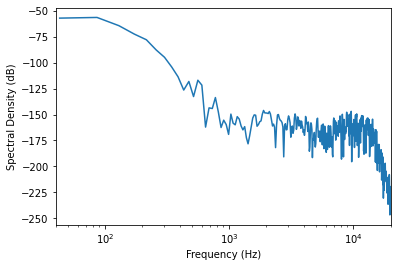

Original:   -15.83 dB
A-weighted: -33.91 dB
K-weighted: -18.20 dB
A, deviation: 1.1787936104142121e-07
A, logstd: 111.21694866564063
A, mdiff: 102.49097230145281


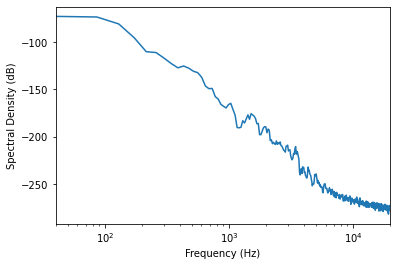

Original:   -9.21 dB
A-weighted: -29.79 dB
K-weighted: -11.74 dB
A, deviation: 4.2752967805885096e-07
A, logstd: 119.87560685433354
A, mdiff: 111.14837201489712


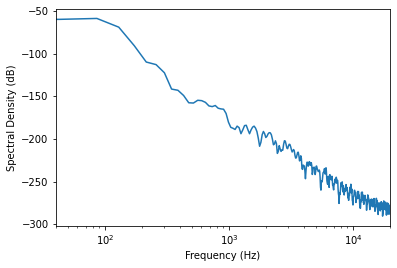

Original:   -12.11 dB
A-weighted: -19.95 dB
K-weighted: -12.53 dB
A, deviation: 8.034700941522495e-07
A, logstd: 42.4181446842192
A, mdiff: 27.111423564909643


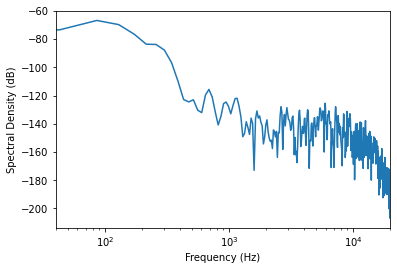

Original:   -4.81 dB
A-weighted: -11.63 dB
K-weighted: -6.97 dB
A, deviation: 2.109671136748772e-06
A, logstd: 17.8685450333502
A, mdiff: 6.303527515137247


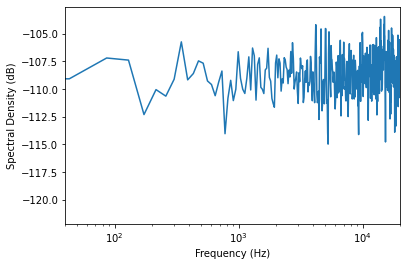

In [26]:
plt_aweighting(sample1.numpy(), savefig='psd1.tex')
plt_aweighting(sample2.numpy())
plt_aweighting(sample3.numpy())
plt_aweighting(torchaudio.load("../sampleset/full/WDH_KICK086.wav")[0][0].numpy())
plt_aweighting(np.random.rand(12000))

A large issue with these calculations is that the Fourier transform bins grow closer together as the frequencies increase, whereas the perceptual difference between these frequencies decreases. For example, the perceptual difference between 100 and 200 Hz is much larger than the perceptual difference between 1000 Hz and 1100 Hz. 

## Pytorch Mel scale FFT

In [12]:
from torchaudio.transforms import MelScale, Spectrogram
from torch import Tensor

filt_b, filt_a = A_weighting(Fs)
def A_filter(waveform):
    return torchaudio.functional.lfilter(waveform, Tensor(filt_a), Tensor(filt_b))

def K_filter(waveform):
    return torchaudio.functional.lfilter(waveform, Tensor(kfilt_a), Tensor(kfilt_b))

mels = MelScale(n_mels = 128, sample_rate=Fs, f_min = 20, f_max = 20000)
spec = Spectrogram(n_fft = 8192)

def mel_flatness_test(sample):
#     weighted = K_filter(sample)
    weighted = sample
    spectrogram = spec.forward(weighted)
    melgram = mels.forward(spectrogram).mean(1).log10().mul(20)
    plt.plot(melgram)
#     plt.plot(-.25 * np.arange(0,128) + 1.25*melgram.mean().numpy())
    plt.plot([0,128],[melgram.mean(),melgram.mean()])
    print(melgram.std())
    plt.show()

tensor(19.6233)


C:\Users\damen\anaconda3\lib\site-packages\torch\functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
C:\Users\damen\anaconda3\lib\site-packages\torch\functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


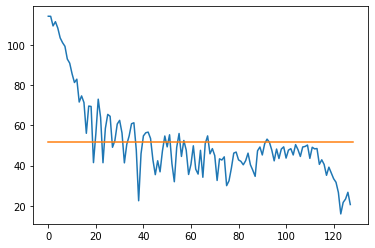

tensor(53.7692)


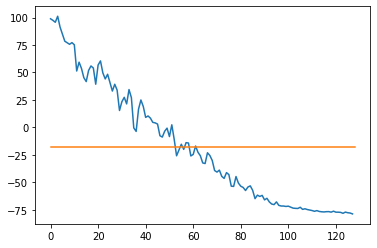

tensor(40.2710)


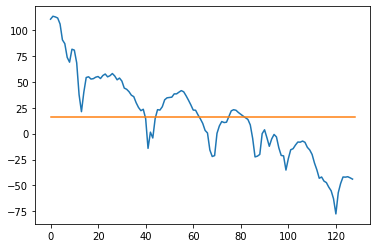

tensor(30.8251)


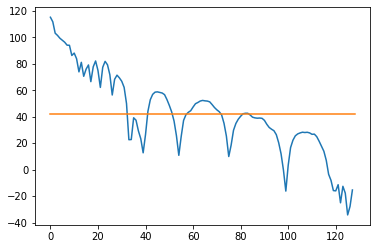

tensor(42.4573)


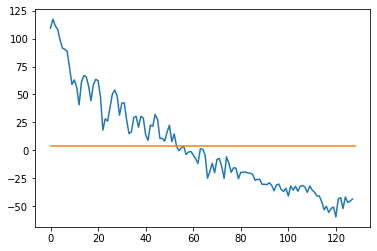

tensor(13.7476)


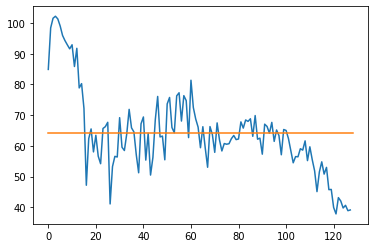

tensor(8.7648)


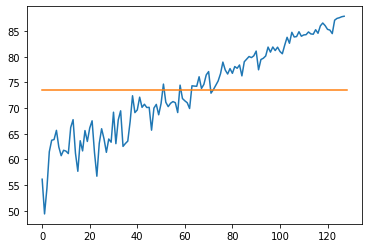

In [13]:
mel_flatness_test(sample1)
mel_flatness_test(sample2)
mel_flatness_test(sample3)
mel_flatness_test(sample4)
mel_flatness_test(sample5)
mel_flatness_test(torchaudio.load("../sampleset/full/WDH_KICK086.wav")[0][0])
mel_flatness_test(Tensor(np.random.rand(12000)))

## Librosa CQT

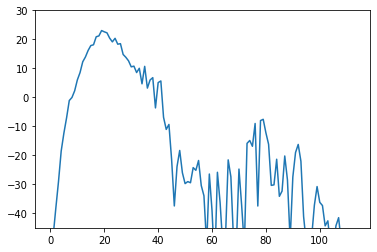

25.250439
0.36434144


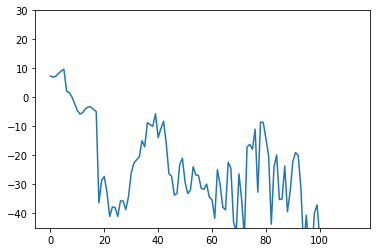

21.70321
0.0045338045


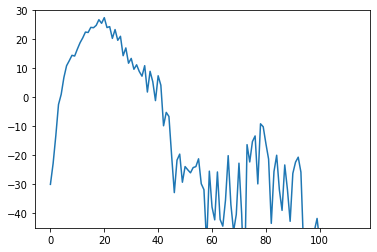

28.400032
0.36686352


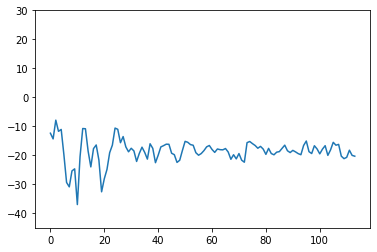

4.0949817
0.08760604


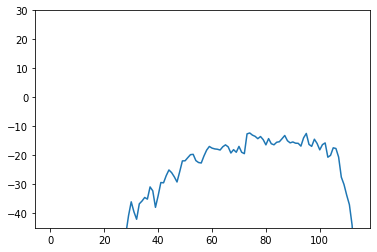

18.74957
0.1917155


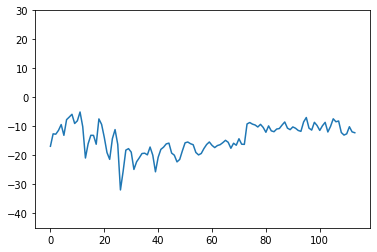

4.8792906
0.50123054


In [14]:
import librosa
from quality.utils import moving_avg

def plt_cqt(sample):
    cq = librosa.cqt(sample, sr=Fs, fmin=30, n_bins=114)
    tens_cq = Tensor(np.abs(cq)**2)
    mav = tens_cq.mean(1).log10().mul(20).numpy()
    plt.plot(mav)
#     plt.yscale('log')
    plt.ylim([-45, 30])
    plt.show()
    print(deviation(mav))

test_sample = torchaudio.load("../sampleset/full/WDH_KICK086.wav")[0][0]
plt_cqt(K_filter(test_sample).numpy())
print(np.mean(librosa.feature.spectral_flatness(K_filter(test_sample).numpy(), hop_length=2048)))
plt_cqt(A_filter(test_sample).numpy())
print(np.mean(librosa.feature.spectral_flatness(A_filter(test_sample).numpy(), hop_length=2048)))
plt_cqt(test_sample.numpy())
print(np.mean(librosa.feature.spectral_flatness(test_sample.numpy(), hop_length=2048)))
# plt_cqt(sample2.numpy())
# plt_cqt(sample3.numpy())
# plt_cqt(sample4.numpy())
#white noise tests
white = np.random.rand(12000)
white_a = lfilter(filt_b, filt_a, white)
white_k = lfilter(kfilt_b, kfilt_a, white)
plt_cqt(white)
print(np.mean(librosa.feature.spectral_flatness(white, hop_length=2048)))
plt_cqt(white_a)
print(np.mean(librosa.feature.spectral_flatness(white_a, hop_length=2048)))
plt_cqt(white_k)
print(np.mean(librosa.feature.spectral_flatness(white_k, hop_length=2048)))


start:  19
[-0.58686018 26.43344802]
[57.11815679]


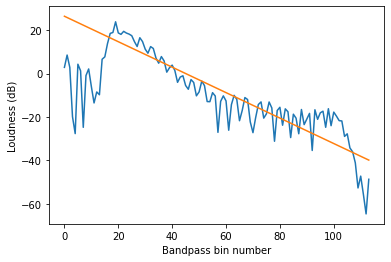

start:  17
[-1.13923002 39.81141026]
[41.9423733]


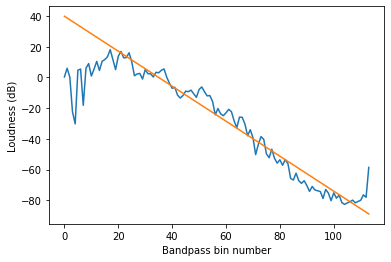

start:  9
[-0.00845122 -6.79844449]
[15.40021615]


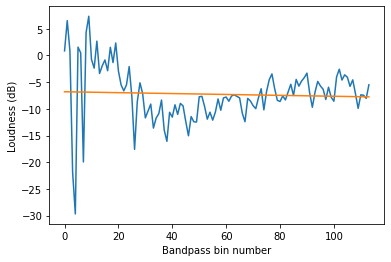

start:  22
[-0.38906339 21.12646969]
[51.08257011]


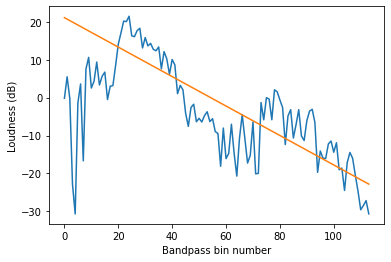

In [15]:
def plot_percept(sample, savefig=None):
    sample = librosa.effects.trim(sample, top_db=50)[0]
    cq = np.abs(librosa.cqt(sample[0:2200], sr=Fs, fmin=30.5, n_bins=114))
    freqs = librosa.cqt_frequencies(cq.shape[0], fmin=30)
#     percept_cqt = librosa.perceptual_weighting(cq**2, freqs, ref=np.max)
#     spectrum = np.mean(percept_cqt,1)
    spectrum = 20*np.log10(np.mean(cq,1))
    start = np.argmax(spectrum[0:24])
#     start=0
    print("start: ", start)
    x = np.arange(start,114)
    linear_model,r1,_,_,_=np.polyfit(x,spectrum[start:114],1,full=True)
    linear_model_fn=np.poly1d(linear_model)
    print(linear_model)
    print(r1/(114-start))
    plt.plot(spectrum)
    plt.plot(linear_model_fn(np.arange(0,114)))
    plt.xlabel('Bandpass bin number')
    plt.ylabel('Loudness (dB)')
    if savefig is not None:
        tikzplotlib.clean_figure()
        tikzplotlib.save(savefig, axis_width='3.52in', axis_height='2.64in')
    plt.show()

plot_percept(K_filter(sample1).numpy(), savefig='cqt.tex')
plot_percept(K_filter(sample2).numpy())
plot_percept(white_k)
plot_percept(lfilter(kfilt_b, kfilt_a, torchaudio.load("../sampleset/full/WDH_KICK086.wav")[0][0].numpy()))

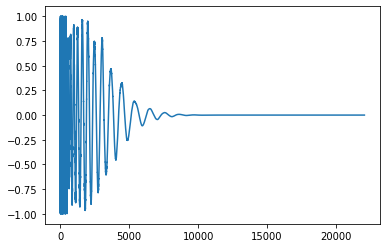

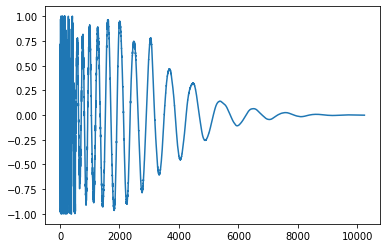

In [16]:
to_trim_sample = torchaudio.load("../sampleset/full/WDH_KICK086.wav")[0][0].numpy()
trimmed_sample = librosa.effects.trim(to_trim_sample, top_db=50)
plt.plot(to_trim_sample)
plt.show()
plt.plot(trimmed_sample[0])
plt.show()

In [17]:
def linfit_qual(sample):
    sample = librosa.effects.trim(sample, top_db=40)[0]
    sample = lfilter(kfilt_b, kfilt_a, sample[0:2205])
    cq = np.abs(librosa.cqt(sample, sr=Fs, fmin=30, n_bins=114))
    spectrum = 20*np.log10(np.mean(cq,1))
    start = np.argmax(spectrum[0:24])
    x = np.arange(start,114)
    linear_model,res,_,_,_=np.polyfit(x,spectrum[start:114],1,full=True)
    slope = linear_model[0]
    res = res[0] / len(spectrum)
    return slope, res
    

In [70]:
import os

lfqs = []

for f in os.listdir('../sampleset/full'):
    sample = torchaudio.load("../sampleset/full/" + f)[0][0]
    lf = linfit_qual(sample.numpy())
    lfqs.append(lf)

CYCdh_ElecK03-Kick01.wav (-1.146293278758187, 36.42879939783423) 0.892008476349524
Kick Alessya DS 1.wav (-1.2674695432880707, 71.54687749054595) 1.1536570532502544
Kick Alessya DS 2.wav (-1.1416669892646538, 82.94231509559134) 1.0734362496470191
Kick Earthy 2.wav (-1.0879637419563468, 77.75921112137969) 0.9990005864418656
Kick-021.wav (-0.9678100239489047, 77.68111353402112) 0.8785344780849892
simplosive-deepkicks-062b.wav (-1.125298401097856, 55.95812010998444) 0.9491308815377937
simplosive-deepkicks2-079a.wav (-1.0856373349031354, 39.696422199962925) 0.844423023702987
Sine_Kick.wav (-0.9002111288858594, 85.78568213749755) 0.8433538574358496
THT_Kicks_11.wav (-1.0000083657237042, 96.3450109290961) 0.9853884094400887
WDH_KICK008.wav (-0.19031963148116554, 40.52024713049792) 1.210482831116164
WDH_KICK023.wav (-0.25601832776103106, 32.72351623574016) 0.8508024261378054
WDH_KICK082.wav (-0.20781453523761487, 43.2450611162541) 1.1339075682769422


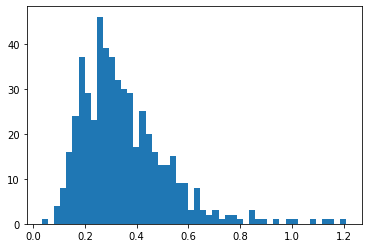

In [72]:
def s(p):
    (slope, res) = p
    slope += 0.4
    if slope < 0:
        slope = -1 * slope
    else:
        slope = 5 * slope #punish upward slopes
    return slope + res/250

for i in range(0,len(lfqs)):
    if(.8 <= s(lfqs[i])):
        print(os.listdir('../sampleset/full')[i], lfqs[i], s(lfqs[i]))

plt.rcParams["hist.bins"] = 50
plt.hist(list(map(s, lfqs)))
plt.show()

In [57]:
for i in range(0,len(lfqs)):
    if s(lfqs[i]) >= .8:
        print(os.listdir('../sampleset/full')[i], lfqs[i])

1 Mr. Bill  Kick.wav (-0.43161501141493014, 39.97584311966386)
11 Mr. Bill Kick.wav (-0.35744370187309343, 31.87066891696662)
12 Mr. Bill Kick.wav (-0.3183193121327653, 33.13059368236465)
16 Mr. Bill Kick.wav (-0.4176757557057627, 31.477764411092277)
6 Mr. Bill Kick.wav (-0.4047227658216647, 36.38726241836593)
8 Mr. Bill Kick.wav (-0.41861547638089397, 32.172895456466655)
Afro_Kick_Oneshot_1.wav (-0.35713476529266064, 59.825170941839694)
Cymatics - Master Collection Kick 12 - F#.wav (-0.43196381578926085, 43.9401832035334)
Cymatics - Ultimate Kick 23 - F#.wav (-0.40031136836093095, 36.089833845881394)
Cymatics - Ultimate Kick 41 - A.wav (-0.40509930654232473, 58.16678416154785)
Glitch Hop Kick.wav (-0.3185182014983376, 43.229387644908606)
JH_Kick_Oneshot_Big_3.wav (-0.37116744647615724, 26.372146379574033)
JH_Kick_Oneshot_Digi.wav (-0.3385891609544531, 56.598628008016014)
Kick Alessya DS 1.wav (-1.2674695432880707, 71.54687749054595)
Kick Alessya DS 2.wav (-1.1416669892646538, 82.94231

start:  9
[-0.51227179  6.31108788]
[151.59812696]


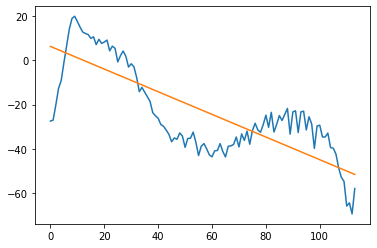

In [20]:
plot_percept(lfilter(kfilt_b, kfilt_a, torchaudio.load("../sampleset/full/WDH_KICK_G01.wav")[0][0].numpy()))

In [21]:
for i in range(0,len(lfqs)):
    if lfqs[i] <= .6:
        print(os.listdir('../sampleset/full')[i], lfqs[i])

TypeError: '<=' not supported between instances of 'tuple' and 'float'

start:  21
[-0.27066713 11.6493596 ]
[46.31578896]


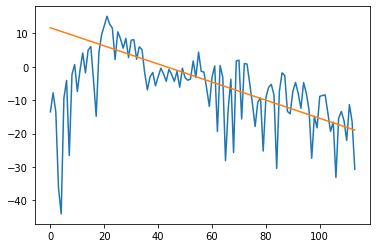

In [58]:
plot_percept(lfilter(kfilt_b, kfilt_a, torchaudio.load("../sampleset/full/WDH_KICK081.wav")[0][0].numpy()))

In [ ]:
for i in range(0,len(lfqs)):
    if os.listdir('../sampleset/full')[i] == "A_Kick_09.wav":
        print(os.listdir('../sampleset/full')[i], lfqs[i])

start:  13
[-0.54697347 23.61851167]
[48.47644577]


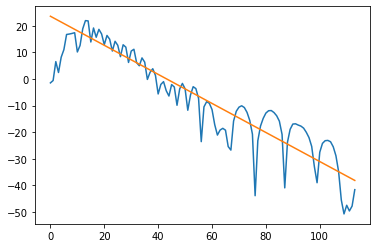

In [87]:
plot_percept(lfilter(kfilt_b, kfilt_a, torchaudio.load("../sampleset/full/A_Kick_09.wav")[0][0][0:4096].numpy()))

In [ ]:
plt.plot(torchaudio.load("../sampleset/full/A_Kick_09.wav")[0][0][0:4096].numpy())
plt.show()

SyntaxError: invalid syntax (<ipython-input-1-1f5ce28b23dc>, line 4)